In [1]:
!pip install category_encoders==2.*

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 2.6 MB/s 


In [2]:
!pip install pyLDAvis==3.3.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 24.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=714389d85b3feb0de77263df7cb96efda6b23cff9327d8fd5740f8ac97f22770
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


In [399]:
from google.colab import files
import category_encoders, io
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import pyLDAvis
import pyLDAvis.gensim_models
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download(['stopwords', 'wordnet', 'omw-1.4'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [4]:
up = files.upload()

Saving titles.csv to titles.csv


In [435]:
df_titles = pd.read_csv(io.BytesIO(up['titles.csv']))

In [436]:
df_titles.head()

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,48,['documentation'],['US'],1.0,NaN,NaN,NaN,0.600,NaN
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,113,"['crime', 'drama']",['US'],NaN,tt0075314,8.3,795222.0,27.612,8.2
2,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['comedy', 'fantasy']",['GB'],NaN,tt0071853,8.2,530877.0,18.216,7.8
3,tm70993,Life of Brian,MOVIE,"Brian Cohen is an average young Jewish man, bu...",1979,R,94,['comedy'],['GB'],NaN,tt0079470,8.0,392419.0,17.505,7.8
4,tm190788,The Exorcist,MOVIE,12-year-old Regan MacNeil begins to adapt an e...,1973,R,133,['horror'],['US'],NaN,tt0070047,8.1,391942.0,95.337,7.7


In [437]:
df_titles.describe(exclude = object)

,release_year,runtime,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
count,5806.000000,5806.000000,2047.000000,5283.000000,5.267000e+03,5712.000000,5488.000000
mean,2016.013434,77.643989,2.165608,6.533447,2.340719e+04,22.525660,6.818039
std,7.324883,39.474160,2.636207,1.160932,8.713432e+04,68.849177,1.171560
min,1945.000000,0.000000,1.000000,1.500000,5.000000e+00,0.009442,0.500000
25%,2015.000000,44.000000,1.000000,5.800000,5.210000e+02,3.155250,6.100000
50%,2018.000000,84.000000,1.000000,6.600000,2.279000e+03,7.478000,6.900000
75%,2020.000000,105.000000,2.000000,7.400000,1.014400e+04,17.775750,7.500000
max,2022.000000,251.000000,42.000000,9.600000,2.268288e+06,1823.374000,10.000000


In [438]:
df_titles.describe(exclude = np.number)

,id,title,type,description,age_certification,genres,production_countries,imdb_id
count,5806,5805,5806,5788,3196,5806,5806,5362
unique,5806,5751,2,5785,11,1626,449,5362
top,ts300399,The Gift,MOVIE,Five families struggle with the ups and downs ...,TV-MA,['comedy'],['US'],tt0075314
freq,1,3,3759,2,841,510,1950,1


In [439]:
df_titles.isna().sum()

id                         0
title                      1
type                       0
description               18
release_year               0
age_certification       2610
runtime                    0
genres                     0
production_countries       0
seasons                 3759
imdb_id                  444
imdb_score               523
imdb_votes               539
tmdb_popularity           94
tmdb_score               318
dtype: int64

In [440]:
df_num = df_titles.select_dtypes(exclude = 'object')
df_cat = df_titles.select_dtypes(exclude = [int, float])

In [444]:
def tv_cert(x):
    return x in 'TV-MA TV-14 TV-PG TV-Y TV-G TV-Y7 NC-17'.split()

In [445]:
df_tv = df_cat[df_cat['age_certification'].apply(tv_cert)]
df_mv = df_cat[~df_cat['age_certification'].apply(tv_cert)]

###Visualize ratings distributions

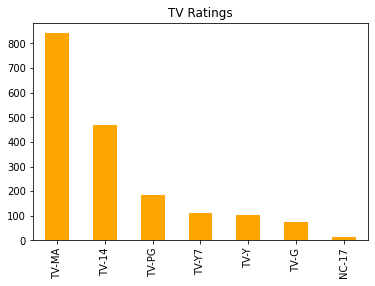

In [446]:
df_tv['age_certification'].value_counts().plot(kind = 'bar', color = 'orange')
plt.title('TV Ratings')
plt.show()

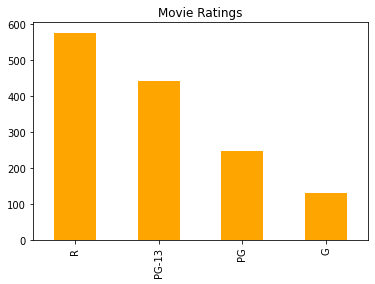

In [447]:
df_mv['age_certification'].value_counts().plot(kind = 'bar', color = 'orange')
plt.title('Movie Ratings')
plt.show()

###Movie vs. show counts

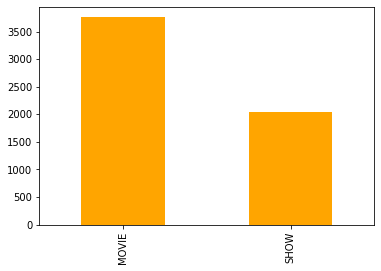

In [448]:
df_cat['type'].value_counts().plot(kind = 'bar', color = 'orange')
plt.show()

In [449]:
df_tv = df_titles[df_titles['age_certification'].apply(tv_cert)]
df_mv = df_titles[~df_titles['age_certification'].apply(tv_cert)]

###Take a look at the average IMDB scores for television and movies.

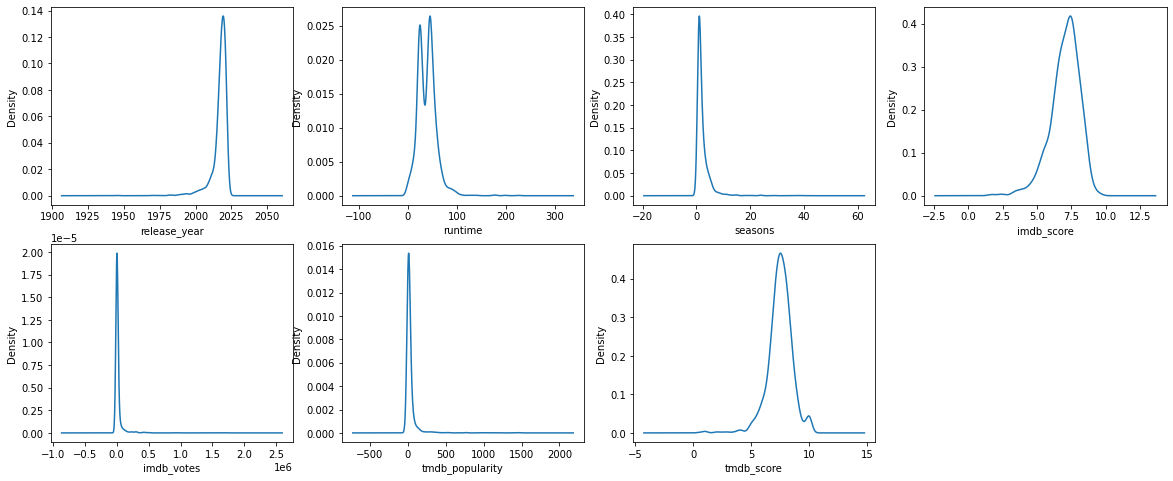

In [450]:
tv_cols = '''release_year runtime seasons imdb_score imdb_votes tmdb_popularity
             tmdb_score'''.split()
plt.figure(figsize = (20, 8))
for i, col in enumerate(tv_cols):
    plt.subplot(2, 4, i + 1)
    df_tv[col].plot(kind = 'density')
    plt.xlabel(col)

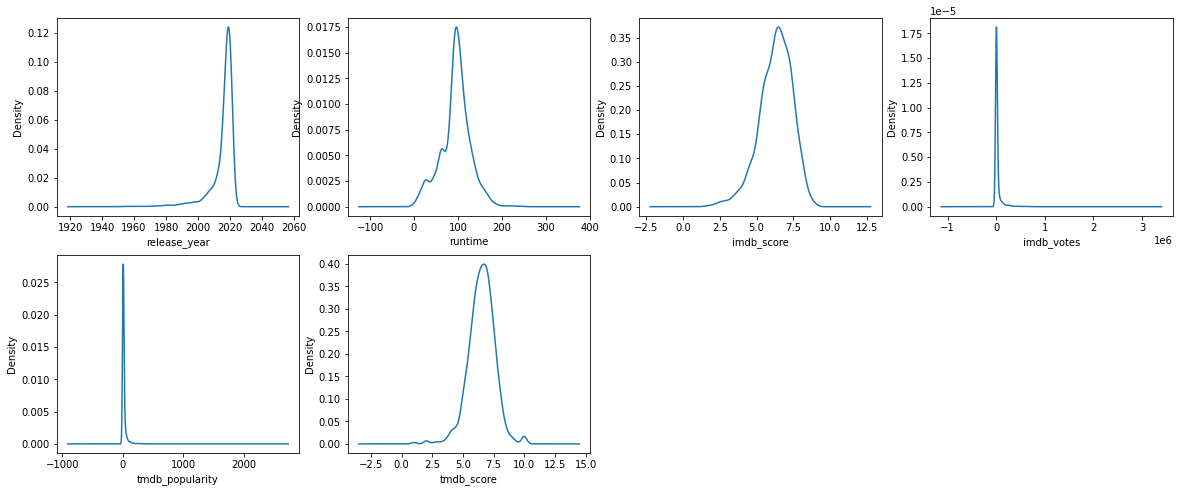

In [451]:
mv_cols = '''release_year runtime imdb_score imdb_votes tmdb_popularity
             tmdb_score'''.split()
plt.figure(figsize = (20, 8))
for i, col in enumerate(mv_cols):
    plt.subplot(2, 4, i + 1)
    df_mv[col].plot(kind = 'density')
    plt.xlabel(col)

###Find the extreme outliers for IMDB score. In our case, outliers will be rows with an imdb_score further than three standard deviations from the mean.

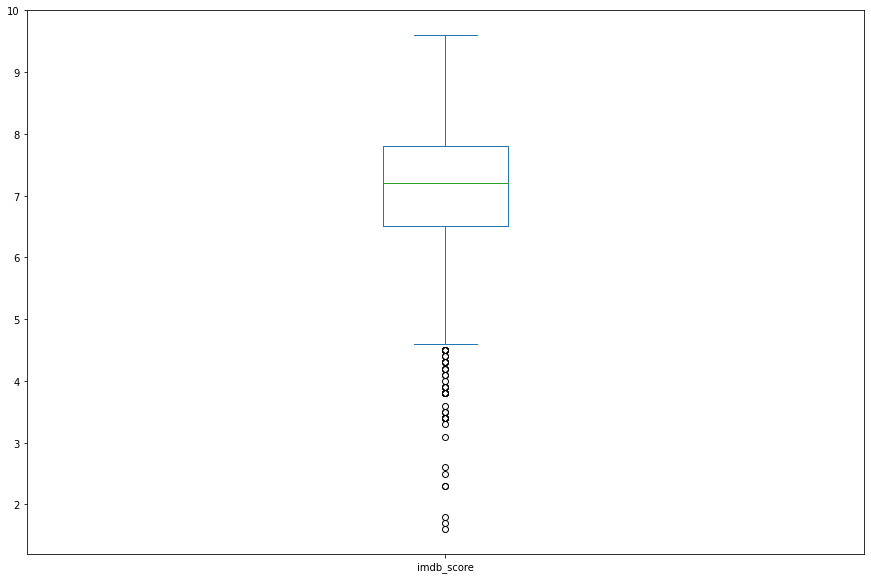

In [452]:
plt.figure(figsize = (15, 10))
df_tv['imdb_score'].plot(kind = 'box')
plt.show()

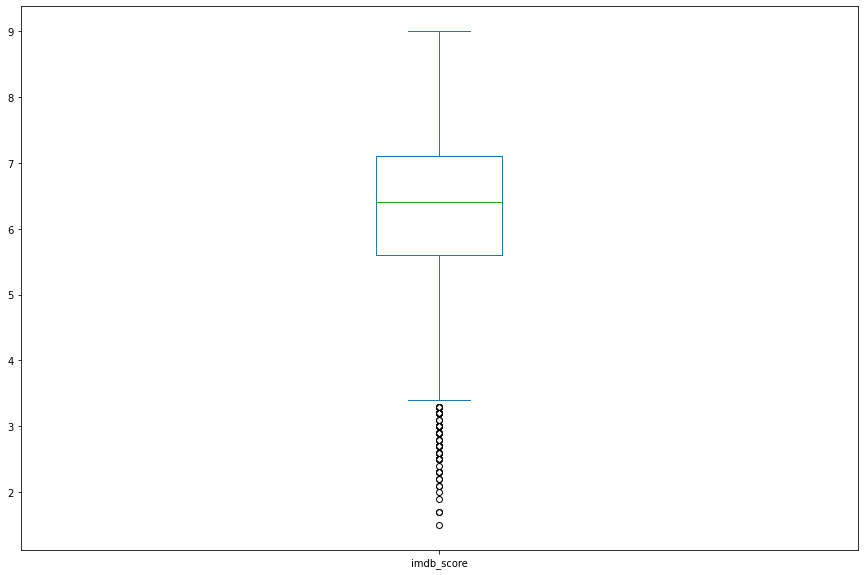

In [453]:
plt.figure(figsize = (15, 10))
df_mv['imdb_score'].plot(kind = 'box')
plt.show()

###Remove the noisy titles, as the descriptions for these titles will not help our natural language analysis.

In [454]:
tv_std, tv_mean = df_tv.imdb_score.std(), df_tv.imdb_score.mean()
mv_std, mv_mean = df_mv.imdb_score.std(), df_mv.imdb_score.mean()
df_tv = df_tv.iloc[[x for x in range(len(df_tv)) if df_tv.iloc[x]['imdb_score']
                     >= (tv_mean - (3 * tv_std)) and df_tv.iloc[x]['imdb_score']
                     <= (tv_mean + (3 * tv_std))]]
df_mv = df_mv.iloc[[x for x in range(len(df_mv)) if df_mv.iloc[x]['imdb_score']
                     >= (mv_mean - (3 * mv_std)) and df_mv.iloc[x]['imdb_score']
                     <= (mv_mean + (3 * mv_std))]]

In [455]:
ord_enc = category_encoders.OrdinalEncoder(cols = 'genres')
df_genre_corr_tv = ord_enc.fit_transform(df_tv)
df_genre_corr_mv = ord_enc.fit_transform(df_mv)

###Ordinal encoding shows there is a correlation between the genres feature and seasons, let's try one hot encoding to see which specific genres yield more seasons.

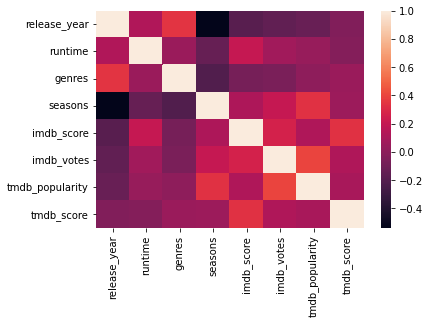

In [456]:
df_genre_corr_tv.head()
sns.heatmap(df_genre_corr_tv.select_dtypes(include = np.number).corr())
plt.show()

In [457]:
lst = list()
for genres in df_titles['genres']:
    lamb = lambda x: x.isalpha()
    re = [''.join(filter(lamb, g)) for g in genres.split(',')]
    lst.extend(set(re))
genres = [g for g in list(set(lst)) if g]

In [459]:
len(genres)

19

In [460]:
for genre in genres:
    df_titles[genre] = df_titles['genres'].apply(lambda x: int(genre in x))

In [461]:
df_titles.drop(columns = 'genres', inplace = True)

In [462]:
df_tv = df_titles[df_titles['age_certification'].apply(tv_cert)]
df_mv = df_titles[~df_titles['age_certification'].apply(tv_cert)]
tv_std, tv_mean = df_tv.imdb_score.std(), df_tv.imdb_score.mean()
mv_std, mv_mean = df_mv.imdb_score.std(), df_mv.imdb_score.mean()
df_tv = df_tv.iloc[[x for x in range(len(df_tv)) if df_tv.iloc[x]['imdb_score']
                     >= (tv_mean - (3 * tv_std)) and df_tv.iloc[x]['imdb_score']
                     <= (tv_mean + (3 * tv_std))]]
df_mv = df_mv.iloc[[x for x in range(len(df_mv)) if df_mv.iloc[x]['imdb_score']
                     >= (mv_mean - (3 * mv_std)) and df_mv.iloc[x]['imdb_score']
                     <= (mv_mean + (3 * mv_std))]]

In [463]:
ktv = {}
kmv = {}
genres = ['family', 'music', 'thriller', 'western', 'animation',
       'crime', 'history', 'comedy', 'european', 'action', 'horror',
       'documentation', 'fantasy', 'drama', 'scifi', 'romance',
       'reality', 'war', 'sport']
for genre in genres:
    ktv[genre] = df_tv[genre].sum()
    kmv[genre] = df_mv[genre].sum()
s_keystv = reversed(sorted(ktv.keys(), key = lambda x: ktv[x]))
s_keysmv = reversed(sorted(kmv.keys(), key = lambda x: kmv[x]))
countstv = reversed(sorted(ktv.values()))
countsmv = reversed(sorted(kmv.values()))
genre_pops_tv = pd.DataFrame({'counts_tv': countstv}, index = s_keystv)
genre_pops_mv = pd.DataFrame({'counts_mv': countsmv}, index = s_keysmv)

###Popular TV: Drama is the most popular television genre according to our dataset.

In [464]:
genre_pops_tv

,counts_tv
drama,893
comedy,617
action,377
animation,349
crime,330
scifi,329
thriller,323
fantasy,293
documentation,266
family,253


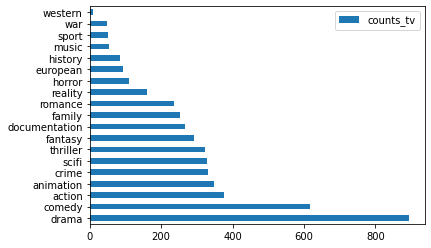

In [465]:
genre_pops_tv.plot(kind = 'barh')
plt.show()

###Popular Movies: The people love drama, and comedy is not far behind.

In [466]:
genre_pops_mv

,counts_mv
drama,1857
comedy,1507
thriller,799
romance,702
action,637
documentation,543
crime,538
european,346
family,339
fantasy,319


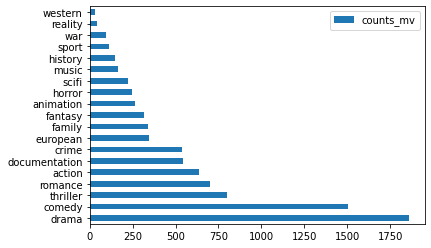

In [467]:
genre_pops_mv.plot(kind = 'barh')
plt.show()

In [468]:
df_tv_corr = df_tv.drop(columns = '''id title type description
             production_countries runtime imdb_id'''.split())

In [469]:
hot_enc = category_encoders.OneHotEncoder(cols = 'age_certification',
                                          use_cat_names = True)
ord_enc = category_encoders.OrdinalEncoder(cols = 'age_certification')

In [470]:
df_tv_corr_ohe = hot_enc.fit_transform(df_tv_corr)
df_tv_corr_ord = ord_enc.fit_transform(df_tv_corr)

###Age certification appears to have a correlation with number of seasons, lets look into this further.

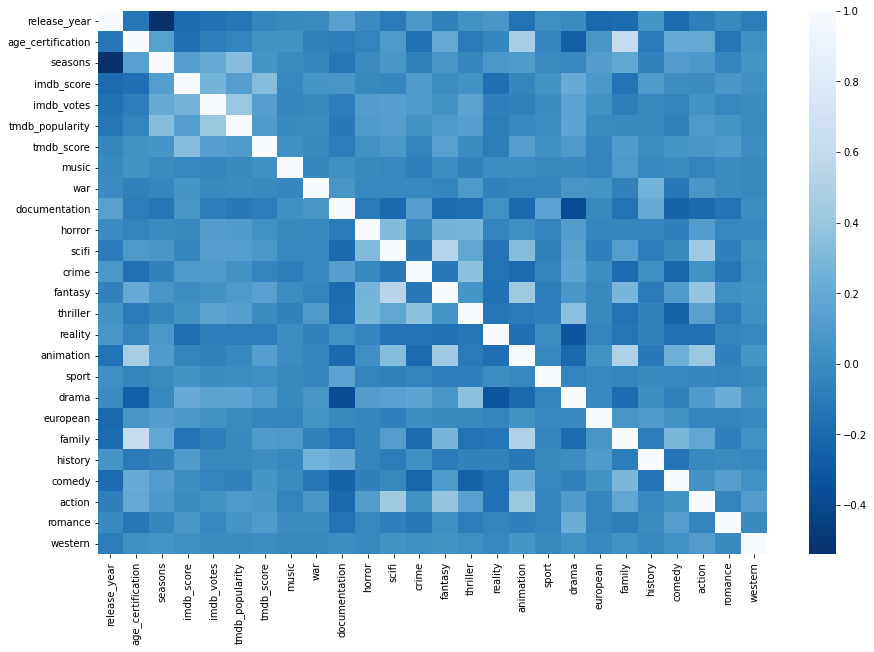

In [471]:
plt.figure(figsize = (15, 10))
sns.heatmap(df_tv_corr_ord.corr(), cmap = 'Blues_r')
plt.show()

###TV-Y7 rated shows and family oriented shows average the most seasons.

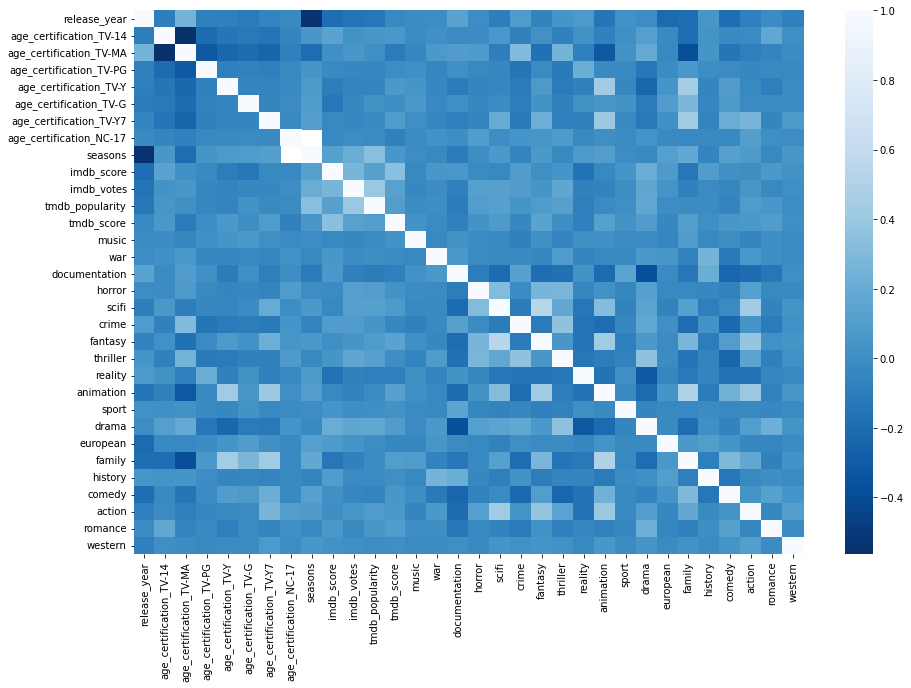

In [472]:
plt.figure(figsize = (15, 10))
sns.heatmap(df_tv_corr_ohe.corr(), cmap = 'Blues_r')
plt.show()

In [473]:
df_mv_corr = hot_enc.fit_transform(df_mv)
df_mv_corr.drop(columns = '''id title type description production_countries
  seasons imdb_id age_certification_nan'''.split(), inplace = True)

###Documentary movies show the highest correlation with imdb_score, with a coefficient of roughly .3

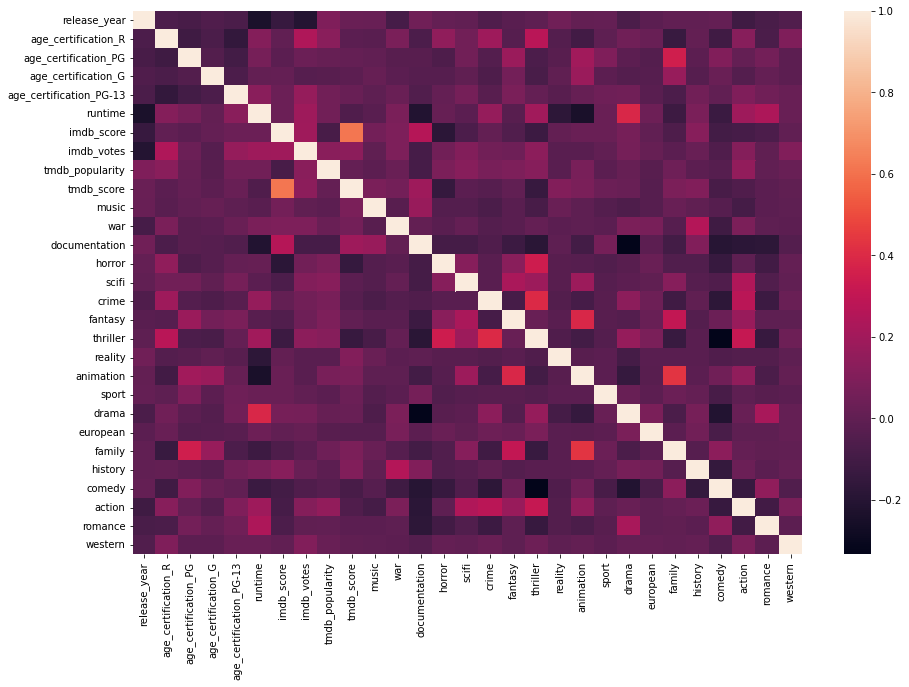

In [474]:
plt.figure(figsize = (15, 10))
sns.heatmap(df_mv_corr.corr())
plt.show()

###What can we learn from the language used to describe each movie or show? Let's dissect the descriptions and find out what words and topics are associated with success.

In [475]:
def cleaner(text):
  text = text.replace('\n', ' ')
  text = re.sub('[^a-z A-Z0-9]', '', text)
  text = re.sub('[ ]{2, }', ' ', text)
  return text.lower().strip()

def tokenizer(text):
  wnl = WordNetLemmatizer()
  lemmas = []
  stops = stopwords.words('english')
  for c in text.split():
    if not sum([c == ' ', c in stops, not c.isalnum()]):
      if len(c) > 1:
        lemmas += [wnl.lemmatize(c)]
  return lemmas

In [476]:
df_tv = df_tv[~df_tv['description'].isna()]
df_mv = df_mv[~df_mv['description'].isna()]

In [479]:
df_tv['lemmas'] = df_tv['description'].apply(lambda x: tokenizer(cleaner(x)))
df_mv['lemmas'] = df_mv['description'].apply(lambda x: tokenizer(cleaner(x)))

In [480]:
id2wordtv = corpora.Dictionary(df_tv['lemmas'])
id2wordmv = corpora.Dictionary(df_mv['lemmas'])
corpustv = [id2wordtv.doc2bow(text) for text in df_tv['lemmas']]
corpusmv = [id2wordmv.doc2bow(text) for text in df_mv['lemmas']]

In [481]:
def compute_coherence_values(dictionary, corpus, texts, limit, start = 2,
                             step = 3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary 
    corpus : Gensim corpus 
    texts : List of input texts 
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the
                       LDA model with respective number of topics
    """
    
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamulticore.LdaMulticore(corpus = corpus,
                                                        id2word = dictionary,
                                                        num_topics = num_topics, 
                                                        chunksize = 100,
                                                        passes = 10,
                                                        random_state = 1234,
                                                        per_word_topics = True,
                                                        workers = 2)
        model_list.append(model)
        coherencemodel = CoherenceModel(model = model, texts = texts,
                                        dictionary = dictionary,
                                        coherence = 'c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [1]:
model_listtv, coh_valstv = compute_coherence_values(dictionary = id2wordtv,
                                                    corpus = corpustv,
                                                    texts = df_tv['lemmas'],
                                                    start = 2, limit = 16,
                                                    step = 1)

In [2]:
model_listmv, coh_valsmv = compute_coherence_values(dictionary = id2wordmv,
                                                    corpus = corpusmv,
                                                    texts = df_mv['lemmas'],
                                                    start = 2, limit = 16,
                                                    step = 1)

In [484]:
max_coherence_val_indextv = np.argmax(coh_valstv)
max_coherence_val_indexmv = np.argmax(coh_valstv)
lda_trained_modeltv = model_listtv[max_coherence_val_indextv]
lda_trained_modelmv = model_listmv[max_coherence_val_indexmv]
lda_trained_modeltv, lda_trained_modelmv

(<gensim.models.ldamulticore.LdaMulticore at 0x7f69bc83e1d0>,
 <gensim.models.ldamulticore.LdaMulticore at 0x7f69c0b42610>)

###Now we can visualize topics by their "word cloud". In other words, what words are each topic made of?
###How many topics are ideal to represent the texts describing shows, and movies?

In [487]:
vis_topic_name_dicttv = {x: f'topic_{x}' for x in range(1, 15)}

In [486]:
pyLDAvis.enable_notebook()
vistv = pyLDAvis.gensim_models.prepare(lda_trained_modeltv, corpustv, id2wordtv)
vistv

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
11     0.055213  0.016634       1        1  9.423049
10     0.126312 -0.012382       2        1  9.353243
4     -0.003739  0.142716       3        1  9.214210
2      0.073058 -0.022833       4        1  8.361290
3      0.130791 -0.025078       5        1  7.944205
7     -0.053577 -0.099564       6        1  7.500518
8      0.053218 -0.023918       7        1  6.608910
12     0.052156  0.031680       8        1  6.493354
5      0.027732 -0.060152       9        1  6.404291
1     -0.037379  0.037421      10        1  6.210735
13    -0.052403  0.067341      11        1  6.200043
9     -0.098801  0.108884      12        1  6.183125
6     -0.116728 -0.186236      13        1  5.595840
0     -0.155851  0.025485      14        1  4.507188, topic_info=            Term        Freq       Total Category  logprob  loglift
164       school   87.000000   87.000000  Default  30.0000  30.0000
9         series  179.000000  179.000000  Default  29.0000  29.0000
865       murder   63.000000   63.000000  Default  28.0000  28.0000
4612  docuseries   45.000000   45.000000  Default  27.0000  27.0000
446         past   43.000000   43.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
340       behind    7.902334   42.938672  Topic14  -5.3463   1.4069
4612  docuseries    7.188353   45.426781  Topic14  -5.4410   1.2559
794        house    5.910501   22.092135  Topic14  -5.6367   1.7810
457      follows    6.359285   53.951128  Topic14  -5.5635   0.9613
408          set    5.079603   59.319555  Topic14  -5.7882   0.6418

[925 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
2144      3  0.885636       18
2474      5  0.871948    1950s
4580      8  0.915598    1960s
4527      8  0.820018    1970s
4527     11  0.164004    1970s
...     ...       ...      ...
2451      5  0.918158  younger
2223      5  0.779992    youre
2223     11  0.129999    youre
3713      9  0.933519      zac
4516      1  0.864888     zuri

[1841 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 11, 5, 3, 4, 8, 9, 13, 6, 2, 14, 10, 7, 1])

In [ ]:
vis_topic_name_dicttv = {x: f'topic_{x}' for x in range(1, 15)}

In [488]:
pyLDAvis.enable_notebook()
vismv = pyLDAvis.gensim_models.prepare(lda_trained_modelmv, corpusmv, id2wordmv)
vismv

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
13     0.229894  0.029624       1        1  14.739586
11     0.168124 -0.004546       2        1  10.261829
4      0.170718 -0.028502       3        1   9.206309
12    -0.002923 -0.129507       4        1   8.600425
5      0.118603  0.115728       5        1   7.514846
8     -0.153997  0.146540       6        1   6.704430
7     -0.025579 -0.050948       7        1   6.145771
2     -0.127536  0.180270       8        1   5.922198
6     -0.117040 -0.088989       9        1   5.492364
3     -0.079954 -0.081484      10        1   5.367638
0     -0.078456 -0.079406      11        1   5.264471
10    -0.031662  0.061712      12        1   5.234067
9      0.018040  0.014528      13        1   4.974542
1     -0.088233 -0.085019      14        1   4.571525, topic_info=          Term        Freq       Total Category  logprob  loglift
1140   special  153.000000  153.000000  Default  30.0000  30.0000
212       love  402.000000  402.000000  Default  29.0000  29.0000
1319    comedy  122.000000  122.000000  Default  28.0000  28.0000
2686     stage   79.000000   79.000000  Default  27.0000  27.0000
356      woman  303.000000  303.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
94      series   11.863121   91.340381  Topic14  -5.7744   1.0442
759      story   12.672623  325.048095  Topic14  -5.7084  -0.1592
1099     earth   10.974187   41.135052  Topic14  -5.8523   1.7640
765       come   11.174659  145.560979  Topic14  -5.8342   0.5184
219   together   11.125404  129.083052  Topic14  -5.8386   0.6341

[875 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
99         9  0.956413  12yearold
410        6  0.958016      1970s
2525      12  0.914581      1980s
4152      14  0.921778         20
7829      14  0.832806         24
...      ...       ...        ...
98        11  0.012425      young
98        12  0.031062      young
8158      10  0.954182  youngster
4066       3  0.926464      youth
13928     13  0.882123         yu

[1688 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 12, 5, 13, 6, 9, 8, 3, 7, 4, 1, 11, 10, 2])

In [ ]:
vis_topic_name_dictmv = {x: f'topic_{x}' for x in range(1, 15)}

###The number of topics chosen by our Latent Dirichlet Algorithm model was 15 for both television and movies! 

In [490]:
def get_topic_id_lookup_dict(vis, vis_topic_name_dict):
    # sync the ordering of topics between the pyLDAvis tool and the lda model

    model_vis_topic_ids = vis.topic_coordinates.topics.to_dict()
    return {k:vis_topic_name_dict[v]  for k, v in model_vis_topic_ids.items()}

In [491]:
topic_name_dicttv = get_topic_id_lookup_dict(vistv, vis_topic_name_dicttv)
topic_name_dictmv = get_topic_id_lookup_dict(vismv, vis_topic_name_dictmv)

In [492]:
def get_topic_ids_for_docs(lda_model, corpus):
    """
    Parameters
    ----------
    lda_model: Gensim object
        Must be a trained model 
        
    corpus: nested lists of tuples, 
        i.e. [[(),(), ..., ()], [(),(), ..., ()], ..., [(),(), ..., ()]]
        
    Returns
    -------
    topic_id_list: list
        Contains topic ids for all document vectors in corpus 
    """
    
    doc_topic_ids = []
    for doc_bow in corpus:
        topic_ids = []
        topic_probs = []
        topic_id_prob_tuples = lda_model.get_document_topics(doc_bow)
        for topic_id_prob in topic_id_prob_tuples:
            topic_id = topic_id_prob[0]
            topic_prob = topic_id_prob[1]
            topic_ids.append(topic_id)
            topic_probs.append(topic_prob)
        max_topic_prob_ind = np.argmax(topic_probs)
        max_prob_topic_id = topic_ids[max_topic_prob_ind]
        doc_topic_ids.append(max_prob_topic_id)
        
    return doc_topic_ids

In [493]:
topic_id_listtv = get_topic_ids_for_docs(lda_trained_modeltv, corpustv)
topic_id_listmv = get_topic_ids_for_docs(lda_trained_modelmv, corpusmv)
df_tv["topic_id"] = topic_id_listtv
df_mv["topic_id"] = topic_id_listmv

In [494]:
df_tv['topic'] = df_tv['topic_id'].apply(lambda x: topic_name_dicttv[x])
df_mv['topic'] = df_mv['topic_id'].apply(lambda x: topic_name_dictmv[x])
df_tv2 = df_tv.copy()
df_mv2 = df_mv.copy()

In [495]:
df_tv2.drop(columns = '''id title type description age_certification
  production_countries imdb_id imdb_score imdb_votes tmdb_popularity tmdb_score
  sport scifi documentation music action crime family animation reality comedy
  war european fantasy drama history horror western romance thriller lemmas
  topic_id'''.split(), inplace = True)

df_mv2.drop(columns = '''id title type description age_certification
  production_countries imdb_id imdb_votes seasons sport scifi documentation
  music action crime family animation reality comedy war european fantasy drama
  history horror western romance thriller lemmas topic_id'''.split(),
  inplace = True)

In [496]:
hot_enc = category_encoders.OneHotEncoder(cols = 'topic', use_cat_names = True)
df_tv2 = hot_enc.fit_transform(df_tv2)
df_mv2 = hot_enc.fit_transform(df_mv2)

###Shows concerning topic 8 have the highest correlation with number of seasons, and several other topics bear a similar relationship.

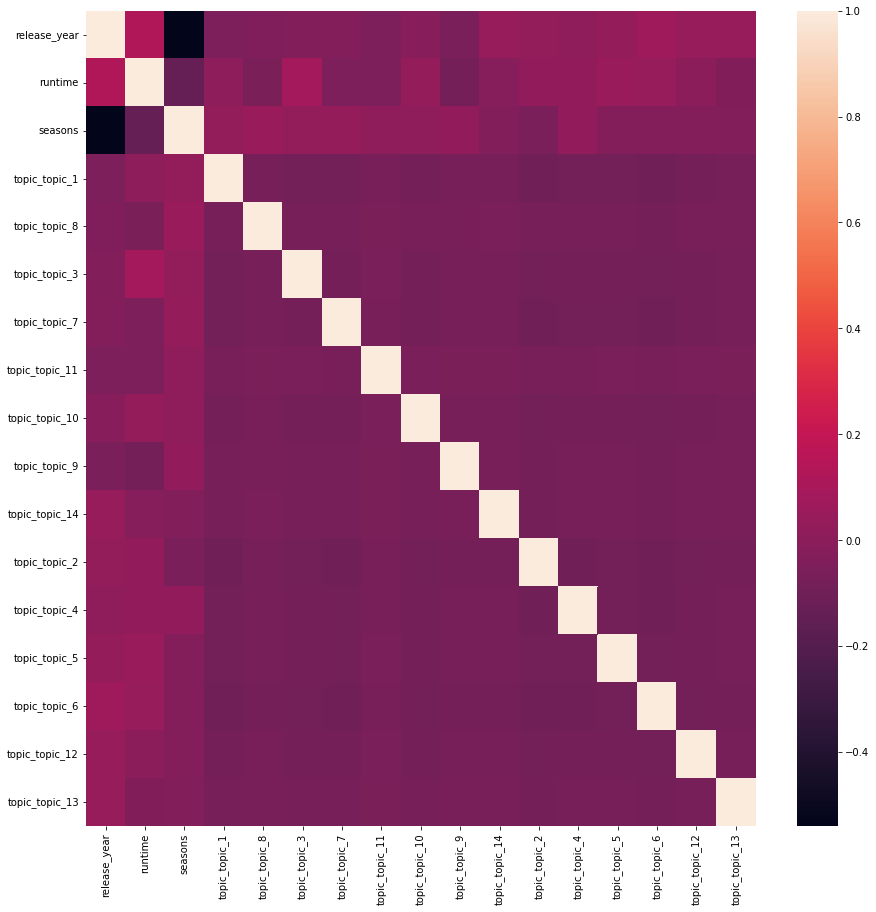

In [498]:
plt.figure(figsize = (15, 15))
sns.heatmap(df_tv2.corr())
plt.show()

###Movies focused on topics 8 and 10 have the highest correlations to imdb_score.

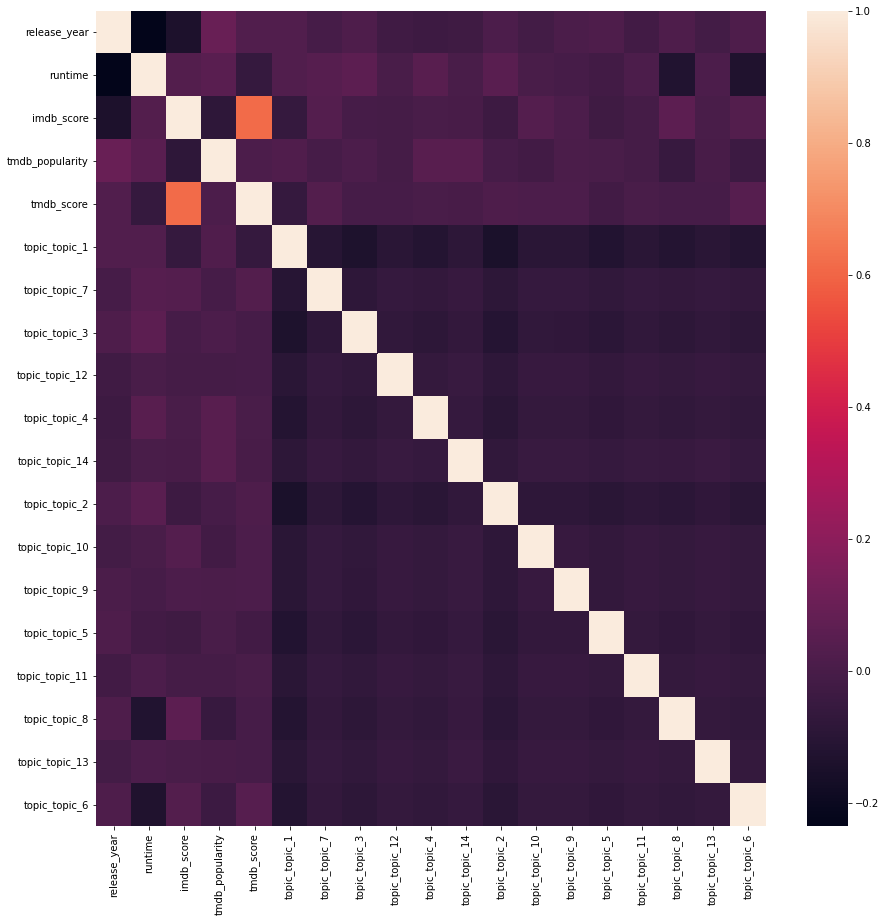

In [499]:
plt.figure(figsize = (15, 15))
sns.heatmap(df_mv2.corr())
plt.show()

In [500]:
lst = list()
for countries in df_titles['production_countries']:
    lamb = lambda x: x.isalpha()
    re = [''.join(filter(lamb, c)) for c in countries.split(',')]
    for x in re:
        lst += [x]
countries = [c for c in list(set(lst)) if c]

In [501]:
countries_dict = {}
for country in countries:
    tv_max_genre, tv_min_genre = '', ''
    mv_max_genre, mv_min_genre = '', ''
    tv_max, tv_min = 0, 0
    mv_max, mv_min = 0, 0
    df_xtv = df_tv[df_tv['production_countries'].apply(
        lambda x: country in x)]
    df_xtv = df_xtv[df_xtv['production_countries'] != '[]']
    df_xmv = df_mv[df_mv['production_countries'].apply(
        lambda x: country in x)]
    df_xmv = df_xmv[df_xmv['production_countries'] != '[]']
    max_top_tv, min_top_tv = df_xtv['topic'].max(), df_xtv['topic'].min()
    max_top_mv, min_top_mv = df_xmv['topic'].max(), df_xtv['topic'].min()
    for genre in df_xtv.columns[14: -3]:
        stv = df_xtv[genre].sum()
        smv = df_xmv[genre].sum()
        if stv > tv_max:
            tv_max, tv_max_genre = stv, genre
        elif stv < tv_min:
            tv_min, tv_min_genre = stv, genre
        if smv > mv_max:
            mv_max, mv_max_genre = smv, genre
        elif smv < mv_min:
            mv_min, mv_min_genre = smv, genre
    countries_dict[country] = [max_top_tv, min_top_tv, tv_max_genre,
                               tv_min_genre, max_top_mv, min_top_mv,
                               mv_max_genre, mv_min_genre]

In [502]:
country_df = pd.DataFrame(countries_dict)

In [503]:
country_df.index = ['max_topic_tv', 'min_topic_tv', 'max_genre_tv',
                    'min_genre_tv', 'max_topic_mv', 'min_topic_mv',
                    'max_genre_mv', 'min_genre_mv']

In [504]:
country_df.drop('min_genre_tv min_genre_mv'.split(), axis = 0, inplace = True)

###The country dataframe holds null values due to the number of topics and genres for a given title occasionally being one or zero. Also, there are numerous countries which only have one title recorded. The null values can be safely ignored in this scenario.

###In working with the new data we've acquired, select countries can be seen popularizing certain topics and genres in the country dataframe.

In [507]:
country_df

,CN,BR,BD,KE,MZ,GR,UA,VA,CD,NL,...,PE,DZ,GT,SK,DK,VN,IQ,TN,CA,TW
max_topic_tv,topic_9,topic_9,NaN,NaN,NaN,NaN,topic_14,NaN,NaN,topic_6,...,topic_13,NaN,NaN,NaN,topic_9,NaN,NaN,NaN,topic_9,topic_9
min_topic_tv,topic_1,topic_1,NaN,NaN,NaN,NaN,topic_14,NaN,NaN,topic_10,...,topic_13,NaN,NaN,NaN,topic_1,NaN,NaN,NaN,topic_1,topic_1
max_genre_tv,drama,documentation,,,,,comedy,,,drama,...,documentation,,,,drama,,,,comedy,drama
max_topic_mv,topic_9,topic_9,topic_4,topic_2,topic_12,topic_1,topic_6,topic_13,topic_4,topic_9,...,topic_9,topic_8,topic_10,topic_7,topic_9,topic_5,topic_7,topic_13,topic_9,topic_9
min_topic_mv,topic_1,topic_1,NaN,NaN,NaN,NaN,topic_14,NaN,NaN,topic_10,...,topic_13,NaN,NaN,NaN,topic_1,NaN,NaN,NaN,topic_1,topic_1
max_genre_mv,drama,comedy,drama,comedy,thriller,drama,documentation,documentation,war,drama,...,drama,crime,documentation,drama,drama,drama,war,drama,drama,drama
